In [1]:
# !pip install statsmodels

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Barcelona_25_01.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Adding 'barcelona' column with values equal to 1
df['barcelona'] = 1

# Adding the 'event' column with values equal to 1
df['event'] = 1

# Display the DataFrame
print(df.shape)

(373, 10)


In [4]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Valencia_25_01.csv'

# Read the CSV file into a DataFrame
V1 = pd.read_csv(file_path)

# Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 1
df = pd.concat([df, V1.assign(barcelona=0, event=1)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)



Updated df after adding rows from V1:
(770, 10)


In [5]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Valencia_19_24.csv'

# Read the CSV file into a DataFrame
V0 = pd.read_csv(file_path)

# Adding rows from V1 to df with 'barcelona' values set to 0 and 'event' values set to 0
df = pd.concat([df, V0.assign(barcelona=0, event=0)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)


Updated df after adding rows from V1:
(1167, 10)


In [6]:
# Specify the path to the CSV file
file_path = 'C:/Users/bakwe/Desktop/BSE/Text_mining/HW1/Scraped_data/Barcelona_19_24.csv'

# Read the CSV file into a DataFrame
B0 = pd.read_csv(file_path)

# Adding rows from B0 to df with 'barcelona' values set to 1 and 'event' values set to 0
df = pd.concat([df, B0.assign(barcelona=1, event=0)], ignore_index=True)

# Displaying the updated df DataFrame
print("\nUpdated df after adding rows from V1:")
print(df.shape)
print(df.columns)


Updated df after adding rows from V1:
(1605, 10)
Index(['Hotels', 'Ratings', 'Distance', 'District', 'Price', 'Link', 'Star',
       'Descriptions', 'barcelona', 'event'],
      dtype='object')


In [7]:
# Create a DataFrame
df = pd.DataFrame(df)

In [8]:
# First, count the occurrences of each value in the 'Hotels' column
hotel_counts = df['Hotels'].value_counts()

# Then, create a new DataFrame containing only rows with 'Hotels' values that appear twice
filtered_df = df[df['Hotels'].isin(hotel_counts[hotel_counts == 2].index)]

# Finally, print the count of 'Hotels' values
print(hotel_counts[hotel_counts == 2])

Oliveira Rooms                      2
NH Barcelona Les Corts              2
Hospes Palau de La Mar              2
Alcam Baro SA                       2
NH Barcelona Stadium                2
                                   ..
Allegro Barcelona                   2
Best Western Premier Hotel Dante    2
BYPILLOW House                      2
The Moods Oasis                     2
Hostal Rio De Castro                2
Name: Hotels, Length: 294, dtype: int64


In [9]:
# # Find the 'Price' value when 'Hotels' is equal to 'Ohla Barcelona'
# ohla_barcelona_price = df.loc[df['Hotels'] == 'Ohla Barcelona', 'Price'].values[0]

# # Print the 'Price' value
# print("Price for 'Hotels' == 'Ohla Barcelona':", ohla_barcelona_price)

In [10]:
# Extract only digits from the 'Price' column and convert to numeric
df['Price'] = pd.to_numeric(df['Price'].str.replace('[^\d]', '', regex=True), errors='coerce')

# Extract the first digit and convert to numeric
df['Star'] = pd.to_numeric(df['Star'].str.extract('(\d)', expand=False), errors='coerce')

# Display the updated DataFrame
print(df.head())

                                Hotels Ratings             Distance  District  \
0         apartment next to park guell     9,0  a 2,7 km del centro       NaN   
1           Melia Barcelona Sky 4* Sup     8,2  a 3,3 km del centro       NaN   
2                Nice room By Eixample     6,7  a 1,3 km del centro       NaN   
3         Mercedes Heritage Apartments     8,5  a 1,5 km del centro       NaN   
4  Gran Hotel La Florida G.L Monumento     8,7  a 5,9 km del centro       NaN   

   Price                                               Link  Star  \
0   1608  https://www.booking.com/hotel/es/apartment-par...     4   
1   3343  https://www.booking.com/hotel/es/melia-barcelo...     4   
2    687  https://www.booking.com/hotel/es/nice-room-for...     5   
3   3565  https://www.booking.com/hotel/es/provenza-mbs....     2   
4   1963  https://www.booking.com/hotel/es/gran-la-flori...     4   

                                        Descriptions  barcelona  event  
0  Apartment next to park

In [11]:
# # Find the 'Price' value when 'Hotels' is equal to 'Ohla Barcelona'
# ohla_barcelona_price = df.loc[df['Hotels'] == 'Ohla Barcelona', 'Price'].values[0]

# # Print the 'Price' value
# print("Price for 'Hotels' == 'Ohla Barcelona':", ohla_barcelona_price)

In [12]:
# Display the count of NaN values in each column
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Hotels        1605 non-null   object 
 1   Ratings       1605 non-null   object 
 2   Distance      1605 non-null   object 
 3   District      0 non-null      float64
 4   Price         1605 non-null   int64  
 5   Link          1605 non-null   object 
 6   Star          1605 non-null   int64  
 7   Descriptions  1605 non-null   object 
 8   barcelona     1605 non-null   int64  
 9   event         1605 non-null   int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 125.5+ KB
None


In [13]:
# Group the DataFrame by 'barcelona' and 'event' columns and calculate the mean of 'Price'
result = df.groupby(['barcelona', 'event'])['Price'].mean().reset_index()

# Order the result DataFrame by the 'Star' column
# result = result.sort_values(by=['Star'])

# 'result' will now contain the average 'Price' for each combination of 'barcelona' and 'event'
print(result)

   barcelona  event        Price
0          0      0   543.413098
1          0      1   722.267003
2          1      0   742.762557
3          1      1  1857.469169


In [14]:
# Count the occurrences of each unique value in the 'Star' column
star_counts = df['Star'].value_counts()

# Print the count of values for each unique 'Star'
print(star_counts)

4    846
3    528
2    139
1     49
5     43
Name: Star, dtype: int64


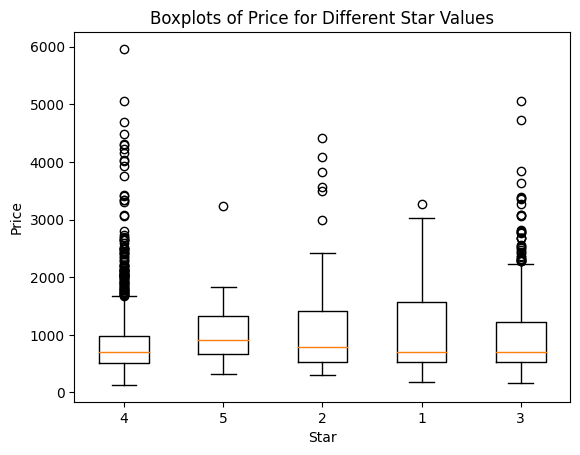

In [15]:
# Group the DataFrame by the 'Star' column and create boxplots for each group
plt.boxplot([df['Price'][df['Star'] == star] for star in df['Star'].unique()], 
            labels=df['Star'].unique())
plt.xlabel('Star')
plt.ylabel('Price')
plt.title('Boxplots of Price for Different Star Values')
plt.show()

In [16]:
# Independent variables
X = df[['barcelona']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.575
Model:                            OLS   Adj. R-squared (uncentered):              0.574
Method:                 Least Squares   F-statistic:                              2167.
Date:                Wed, 31 Jan 2024   Prob (F-statistic):                   4.50e-300
Time:                        09:03:44   Log-Likelihood:                         -12940.
No. Observations:                1605   AIC:                                  2.588e+04
Df Residuals:                    1604   BIC:                                  2.589e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [17]:
# Independent variables
X = df[['event']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.560
Model:                            OLS   Adj. R-squared (uncentered):              0.560
Method:                 Least Squares   F-statistic:                              2044.
Date:                Wed, 31 Jan 2024   Prob (F-statistic):                   1.84e-288
Time:                        09:03:44   Log-Likelihood:                         -12967.
No. Observations:                1605   AIC:                                  2.594e+04
Df Residuals:                    1604   BIC:                                  2.594e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [18]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'interaction_term']]

# Dependent variable
y = df['Price']

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.780
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              1897.
Date:                Wed, 31 Jan 2024   Prob (F-statistic):                        0.00
Time:                        09:03:44   Log-Likelihood:                         -12410.
No. Observations:                1605   AIC:                                  2.483e+04
Df Residuals:                    1602   BIC:                                  2.484e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

In [19]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model without adding a constant term
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     592.3
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          6.42e-259
Time:                        09:03:45   Log-Likelihood:                -12190.
No. Observations:                1605   AIC:                         2.439e+04
Df Residuals:                    1601   BIC:                         2.441e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              543.4131     24.173  

In [20]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'Star', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     456.2
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          1.67e-262
Time:                        09:03:45   Log-Likelihood:                -12178.
No. Observations:                1605   AIC:                         2.437e+04
Df Residuals:                    1600   BIC:                         2.439e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              281.3679     59.408  

In [21]:
# Create a new column 'Top_star' based on the condition
df['Top_star'] = (df['Star'].isin([4, 5])).astype(int)


In [22]:
# Calculate the number of observations meeting the specified conditions
num_observations = df[(df['barcelona'] == 1) & (df['Top_star'] == 1) & (df['event'] == 1)].shape[0]

# Display the result
print("Number of observations:", num_observations)

Number of observations: 156


In [23]:
# Adding the interaction term
df['interaction_term'] = df['barcelona'] * df['event']

# Independent variables
X = df[['barcelona', 'event', 'Top_star', 'interaction_term']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     452.0
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          8.32e-261
Time:                        09:03:45   Log-Likelihood:                -12182.
No. Observations:                1605   AIC:                         2.437e+04
Df Residuals:                    1600   BIC:                         2.440e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              482.1526     28.705  

In [24]:
# Adding interaction terms
df['interaction_term'] = df['barcelona'] * df['event']
df['interaction_term_all'] = df['barcelona'] * df['event'] * df['Top_star']

# Independent variables
X = df[['barcelona', 'event', 'Top_star', 'interaction_term', 'interaction_term_all']]

# Dependent variable
y = df['Price']

# Adding a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print out the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     365.3
Date:                Wed, 31 Jan 2024   Prob (F-statistic):          2.01e-261
Time:                        09:03:45   Log-Likelihood:                -12178.
No. Observations:                1605   AIC:                         2.437e+04
Df Residuals:                    1599   BIC:                         2.440e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  508.4954 